In [1]:
!pip install shap

In [2]:
!pip install dice-ml

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 52.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 101.7 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.10.1 requires pandas<2.2.3dev0,>=2.0, but you have pandas 1.5.3 which is incompatible.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 1.5.3 which is incompatible.
mizani 0.13.0 requires pandas>=2.2.0, but you have pandas 1.5.3 which is incompatible.
plotnine 0.14.1 requires pandas>=2.2.0, but you have pandas 1.5.3 which is incompatible.
xarray 2024.10.0 requires pandas>=2.1, but you have pandas 1.5.3 which is incompatible.


In [29]:
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import PartialDependenceDisplay
import dice_ml
from dice_ml.utils import helpers

In [4]:
df = pd.read_csv('/content/drive/MyDrive/Colab files/mo436b/framingham.csv')

# Limpeza

In [5]:
columns_to_check = ['education', 'cigsPerDay', 'BPMeds', 'totChol', 'BMI', 'heartRate']  # Replace with your actual column names
df.dropna(subset=columns_to_check, inplace=True)
df_cleaned = df.dropna(subset=columns_to_check)  # To create a new DataFrame without NaNs
mean_glucose = df['glucose'].mean()
df['glucose'].fillna(mean_glucose, inplace=True)

# Ajuste do modelo

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3989 entries, 0 to 4239
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   male             3989 non-null   int64  
 1   age              3989 non-null   int64  
 2   education        3989 non-null   float64
 3   currentSmoker    3989 non-null   int64  
 4   cigsPerDay       3989 non-null   float64
 5   BPMeds           3989 non-null   float64
 6   prevalentStroke  3989 non-null   int64  
 7   prevalentHyp     3989 non-null   int64  
 8   diabetes         3989 non-null   int64  
 9   totChol          3989 non-null   float64
 10  sysBP            3989 non-null   float64
 11  diaBP            3989 non-null   float64
 12  BMI              3989 non-null   float64
 13  heartRate        3989 non-null   float64
 14  glucose          3989 non-null   float64
 15  TenYearCHD       3989 non-null   int64  
dtypes: float64(9), int64(7)
memory usage: 529.8 KB


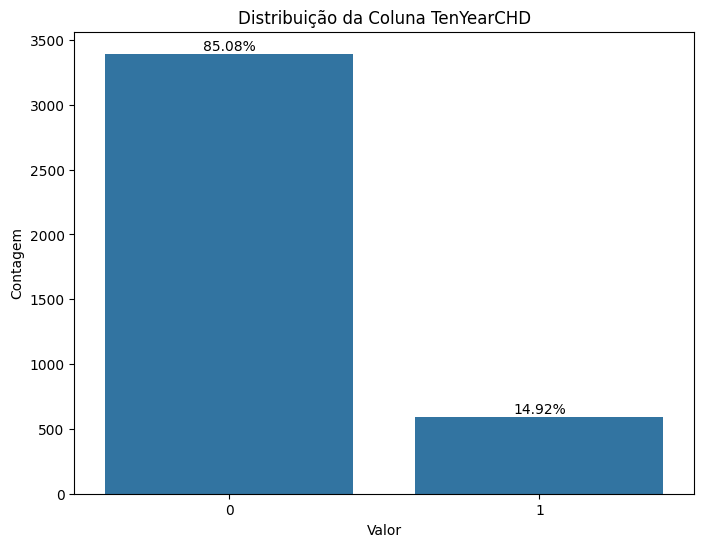

In [12]:

# Calcula a porcentagem de cada valor
percentage_0 = (df['TenYearCHD'] == 0).sum() / len(df) * 100
percentage_1 = (df['TenYearCHD'] == 1).sum() / len(df) * 100

# Cria o gráfico de barras
plt.figure(figsize=(8, 6))
sns.countplot(x='TenYearCHD', data=df)
plt.title('Distribuição da Coluna TenYearCHD')
plt.xlabel('Valor')
plt.ylabel('Contagem')

# Adiciona as porcentagens acima das barras
plt.text(0, (df['TenYearCHD'] == 0).sum(), f'{percentage_0:.2f}%', ha='center', va='bottom')
plt.text(1, (df['TenYearCHD'] == 1).sum(), f'{percentage_1:.2f}%', ha='center', va='bottom')

plt.show()

In [ ]:
df.head()

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,3.0,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


In [6]:
X = df.drop('TenYearCHD', axis=1)  # Substitua 'TenYearCHD' pelo nome da sua variável de saída
y = df['TenYearCHD']

# Dividir em conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Instanciar o modelo de regressão logística
model = LogisticRegression(max_iter=1000)  # max_iter aumentado para garantir convergência

# Treinar o modelo
model.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=1000)

In [8]:
def train_model(model, X_train, y_train):
    model.fit(X_train, y_train)
    return model
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    return accuracy, report

In [9]:
# Fazer previsões no conjunto de teste
y_pred = model.predict(X_test)

# Avaliar o modelo
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f'Acurácia: {accuracy:.2f}')
print('Relatório de Classificação:\n', report)

Acurácia: 0.86
Relatório de Classificação:
               precision    recall  f1-score   support

           0       0.87      0.98      0.92       690
           1       0.29      0.05      0.08       108

    accuracy                           0.86       798
   macro avg       0.58      0.51      0.50       798
weighted avg       0.79      0.86      0.81       798



In [13]:
# Defining the parameter grid based on the base model values
param_grid = {
    'C': [0.1, 0.5, 1.0, 2, 5, 10],               # Variations around the default C value (1.0)
    'penalty': ['l2'],                            # Keeping 'l2' regularization
    'solver': ['lbfgs', 'liblinear', 'saga'],     # Exploring solvers compatible with 'l2'
    'fit_intercept': [True, False],               # Testing with and without intercept
    'tol': [0.0001, 0.001, 0.01],                 # Different tolerance levels for convergence
    'max_iter': [500, 1000, 2000],                # Adjusting iterations for convergence
    'class_weight': ['balanced']                  # Testing with and without class balancing
}

# Instantiating the logistic regression model and setting up the grid search
logistic_model = LogisticRegression()
grid_search = GridSearchCV(logistic_model, param_grid, cv=5, scoring='recall', n_jobs=-1)

# Running the grid search
grid_search.fit(X_train, y_train)

# Best hyperparameter combination
print("Best parameters:", grid_search.best_params_)
print("Best recall score:", grid_search.best_score_)

/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best parameters: {'C': 0.5, 'class_weight': 'balanced', 'fit_intercept': True, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'lbfgs', 'tol': 0.0001}
Best recall score: 0.6693246370713234


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [14]:
best_model = LogisticRegression(
    C=0.5,
    class_weight='balanced',
    fit_intercept=True,
    max_iter=1000,
    penalty='l2',
    solver='lbfgs',
    tol=0.0001
)
best_model = train_model(best_model, X_train, y_train)
accuracy, report = evaluate_model(best_model, X_test, y_test)
print(f'Acurácia: {accuracy:.2f}')
print('Relatório de Classificação:\n', report)

Acurácia: 0.66
Relatório de Classificação:
               precision    recall  f1-score   support

           0       0.94      0.66      0.77       690
           1       0.25      0.71      0.36       108

    accuracy                           0.66       798
   macro avg       0.59      0.68      0.57       798
weighted avg       0.84      0.66      0.72       798



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


# Visualização

## 1. Visualização dos Coeficientes do Modelo

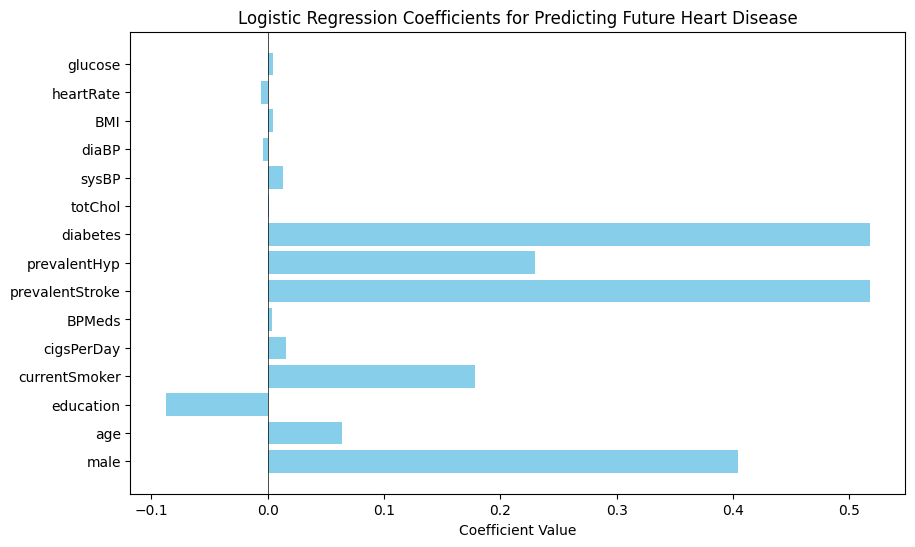

In [16]:
coefficients = best_model.coef_[0]  # Coeficientes da regressão logística
features = X.columns  # Nomes das variáveis

# Visualizar os coeficientes em um gráfico de barras
plt.figure(figsize=(10, 6))
plt.barh(features, coefficients, color='skyblue')
plt.xlabel('Coefficient Value')
plt.title('Logistic Regression Coefficients for Predicting Future Heart Disease')
plt.axvline(0, color='black', linewidth=0.5)
plt.show()

Coeficientes positivos indicam que o aumento do valor da variável aumenta a probabilidade de ocorrer o evento (neste caso, doença cardíaca).
Coeficientes negativos indicam que o aumento do valor da variável diminui essa probabilidade.

obs: posso mudar o nome das features nos gráficos com a ajuda do gpt pra ficar mais legível (tudo em inglês)

## 2. Análise dos Pesos e Importância das Variáveis

Além do gráfico de barras, é útil destacar quais são as variáveis mais importantes. Variáveis com coeficientes absolutos altos têm maior impacto no resultado final.
Você pode classificar as variáveis por importância e listar as mais relevantes para o risco de doença cardíaca.


In [17]:
# Ordenar variáveis por importância (valor absoluto do coeficiente)
sorted_features = np.argsort(np.abs(coefficients))[::-1]
for i in sorted_features[:5]:  # Exibir as 5 variáveis mais importantes
    print(f"{features[i]}: Coeffie = {coefficients[i]:.4f}")

prevalentStroke: Coeffie = 0.5179
diabetes: Coeffie = 0.5179
male: Coeffie = 0.4046
prevalentHyp: Coeffie = 0.2295
currentSmoker: Coeffie = 0.1784


In [18]:
for i in sorted_features[:-3]:  # Exibir as 5 variáveis mais importantes
    print(f"{features[i]}: Coeffie = {coefficients[i]:.4f}")

prevalentStroke: Coeffie = 0.5179
diabetes: Coeffie = 0.5179
male: Coeffie = 0.4046
prevalentHyp: Coeffie = 0.2295
currentSmoker: Coeffie = 0.1784
education: Coeffie = -0.0876
age: Coeffie = 0.0638
cigsPerDay: Coeffie = 0.0161
sysBP: Coeffie = 0.0129
heartRate: Coeffie = -0.0056
glucose: Coeffie = 0.0048
BMI: Coeffie = 0.0045


## 3.  Exemplo de Tendência do Modelo

ISSO É O QUE TA NO SLIDE DE LOGISTIC REGRESSION!

Como o modelo é linear, cada variável influencia diretamente a saída. Você pode explicar a tendência do modelo mostrando, por exemplo, que um aumento em uma variável como "colesterol" leva a uma maior probabilidade de diagnóstico de doença cardíaca, enquanto uma variável como "nível de atividade física" pode ter um coeficiente negativo, indicando proteção contra o risco.

## 4. Visualização de Tendência com Curvas de Probabilidade

Posso gerar para colesterol também e outras variáveis contínuas

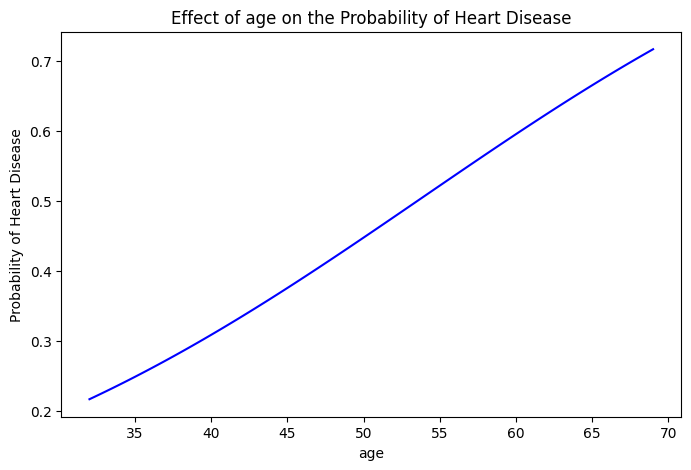

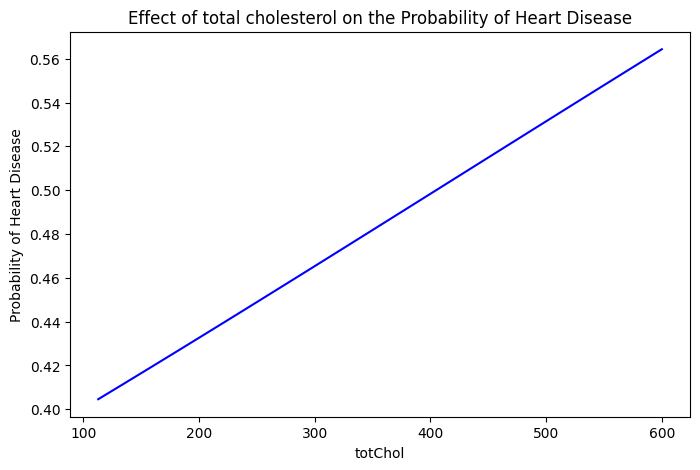

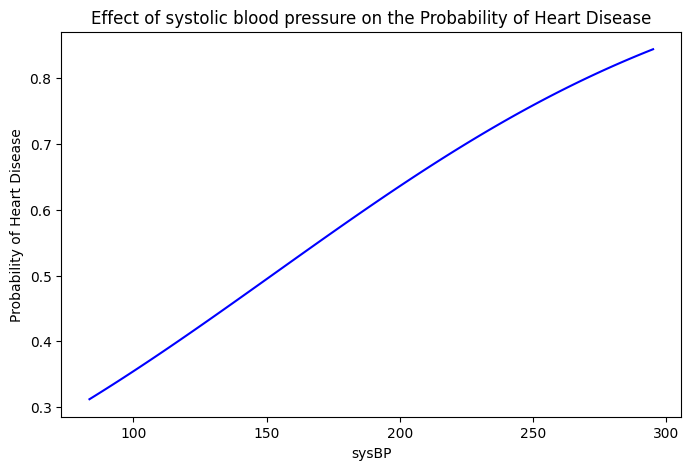

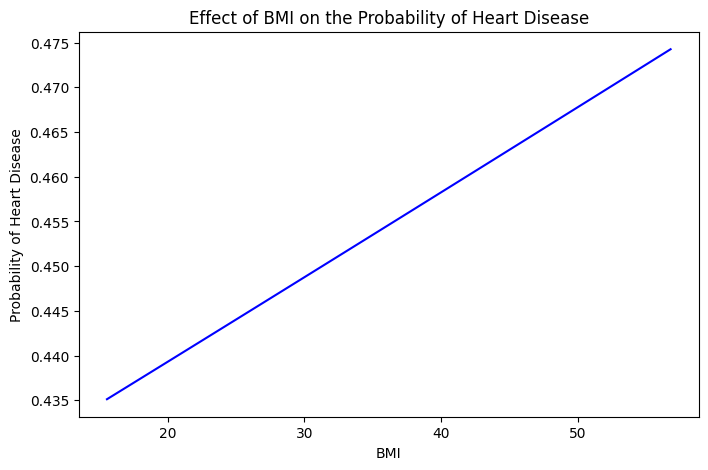

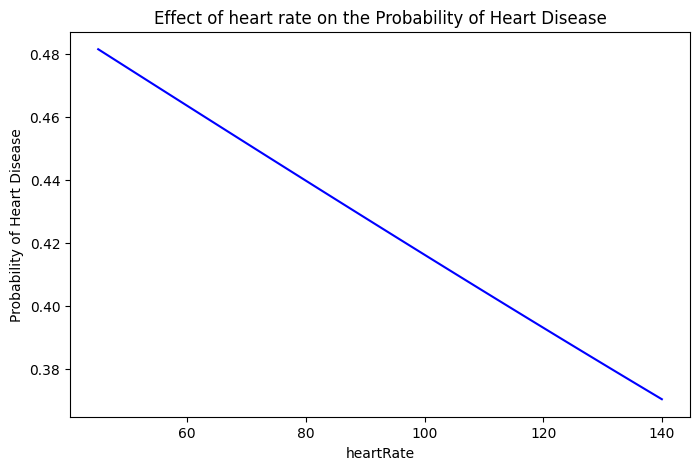

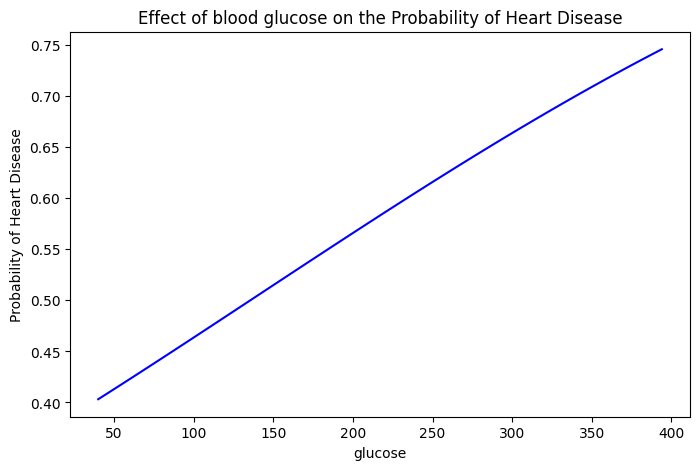

In [27]:
# Lista das variáveis contínuas para análise
features_to_plot = ['age', 'totChol', 'sysBP', 'BMI', 'heartRate', 'glucose']
significate = {'age': 'age', 'totChol': 'total cholesterol', 'sysBP': 'systolic blood pressure', 'BMI': 'BMI', 'heartRate': 'heart rate', 'glucose': 'blood glucose'}
probability_plots = {}

# Loop para gerar gráfico para cada variável contínua
for feature in features_to_plot:
    # Definir o intervalo de valores para a variável selecionada
    feature_range = np.linspace(X_train[feature].min(), X_train[feature].max(), 100)
    probabilities = []

    # Calcular a probabilidade média para cada valor no intervalo, mantendo outras variáveis constantes
    for value in feature_range:
        X_temp = X_train.copy()
        X_temp[feature] = value
        prob = best_model.predict_proba(X_temp)[:, 1].mean()  # Probabilidade média para o valor específico
        probabilities.append(prob)

    # Armazenar as probabilidades para cada feature
    probability_plots[feature] = probabilities

    # Plotar o gráfico da probabilidade em função da variável
    plt.figure(figsize=(8, 5))
    plt.plot(feature_range, probabilities, color='blue')
    plt.xlabel(feature)
    plt.ylabel('Probability of Heart Disease')
    plt.title(f'Effect of {significate[feature]} on the Probability of Heart Disease')
    plt.show()

# Criando um modelo não interpretável

In [23]:
# Train the model on the training set
# Manually tuning with sample parameters
rf_model = RandomForestClassifier(
    n_estimators=500,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    class_weight='balanced',
    random_state=0
)
rf_model.fit(X_train, y_train)
# Prediction on the test set
y_pred = rf_model.predict(X_test)

print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.87      0.97      0.92       690
           1       0.31      0.07      0.12       108

    accuracy                           0.85       798
   macro avg       0.59      0.52      0.52       798
weighted avg       0.79      0.85      0.81       798



In [ ]:
print("Parâmetros do Modelo Random Forest:")
print(rf_model.get_params())

Parâmetros do Modelo Random Forest:
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 0, 'verbose': 0, 'warm_start': False}


## Global approx (PDP)

Explicação para escolha das variáveis

'age': A idade é um fator importante de risco cardiovascular.

'totChol': O nível de colesterol total é um indicador-chave para doenças cardíacas.

'sysBP': A pressão arterial sistólica elevada está associada a maior risco de problemas cardíacos.

'BMI': O Índice de Massa Corporal é outro fator de risco relevante.


glucose: Níveis elevados de glicose são indicativos de diabetes e desregulação metabólica, que são fatores de risco significativos para doenças cardíacas e complicações cardiovasculares a longo prazo.

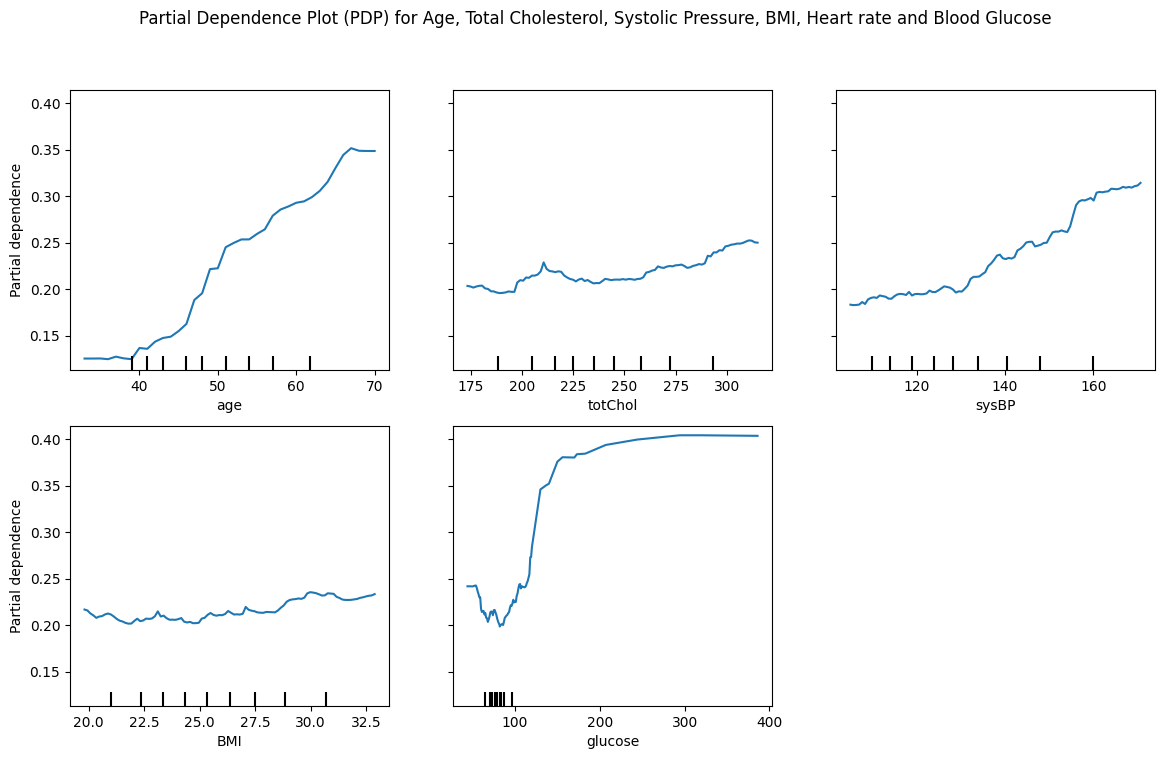

In [25]:
features_to_plot = ['age', 'totChol', 'sysBP', 'BMI', 'glucose']

# Criar o Partial Dependence Plot para as features selecionadas
fig, ax = plt.subplots(figsize=(14, 8))
PartialDependenceDisplay.from_estimator(rf_model, X_test, features_to_plot, ax=ax)

plt.suptitle('Partial Dependence Plot (PDP) for Age, Total Cholesterol, Systolic Pressure, BMI, Heart rate and Blood Glucose')
plt.show()

Interpretar isso

## Local approx (SHAP)

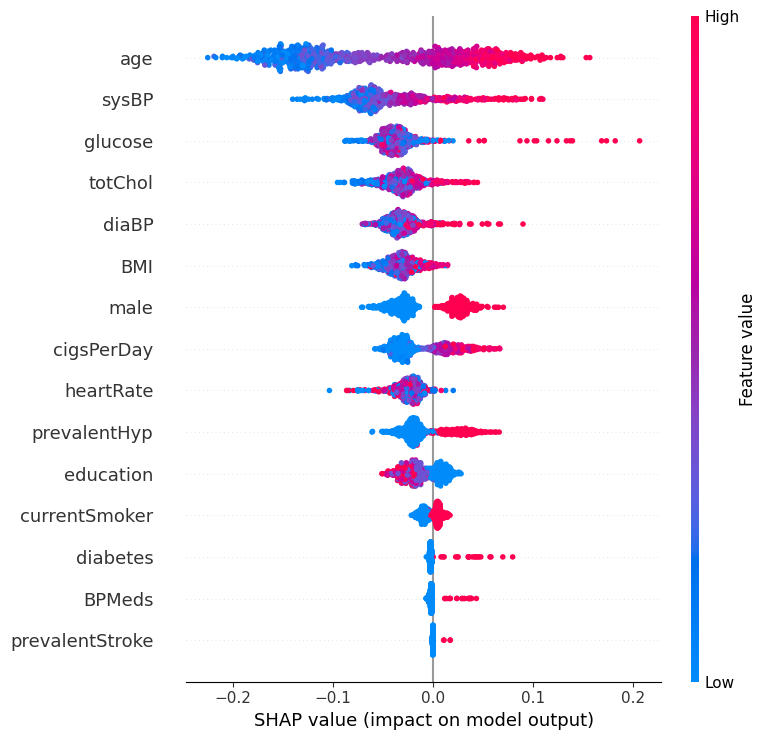

In [26]:
explainer = shap.TreeExplainer(rf_model)

# Calcular os valores SHAP para o conjunto de teste
shap_values = explainer.shap_values(np.array(X_test))

# Plotar o summary plot dos valores SHAP
plt.figure(figsize=(14, 6))
shap.summary_plot(shap_values[:,:,1], X_test)

Explicar isso

# Contrafactual ou Contrastiva

In [30]:
# Configurar o DiCE com o dataframe original que inclui a variável de saída
data = dice_ml.Data(dataframe=df, continuous_features=['age', 'cigsPerDay', 'totChol', 'sysBP', 'BMI', 'glucose'], outcome_name='TenYearCHD')
model = dice_ml.Model(model=rf_model, backend="sklearn")  # Configurar para sklearn

# Configurar o DiCE para explicações contrafactuais
exp = dice_ml.Dice(data, model)

# Selecionar uma instância para gerar contrafactuais (por exemplo, do conjunto de teste)
query_instance = X_test.iloc[0:1]  # Exemplo de primeira instância do conjunto de teste
counterfactuals = exp.generate_counterfactuals(query_instance, total_CFs=3, desired_class="opposite")

# Visualizar os contrafactuais
counterfactuals.visualize_as_dataframe()

100%|██████████| 1/1 [00:00<00:00,  2.05it/s]

Query instance (original outcome : 0)


,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,0,43,3.0,1,5.0,0.0,0,0,0,250.0,110.0,70.0,21.139999,64.0,85.0,0



Diverse Counterfactual set (new outcome: 1)


,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,0,56,3.0,1,5.0,0.0,0,1,0,250.0,110.0,70.0,21.14,64.0,213.21187,1
1,0,56,3.0,1,5.0,0.0,0,1,0,250.0,110.0,70.0,21.14,64.0,213.21187,1
2,0,53,3.0,1,5.0,0.0,0,0,1,250.0,110.0,70.0,21.14,76.0,201.01406,1


Ver a explicação do gpt

RELATAR TUDO ATÉ O MODELO QUE USOU DICE E ETC